# CP2 AI Voice Intelligence System: Gender 
## Recognition, Speech-to-Text & Text Summarization Using NLP 

In [ ]:
import sys
print(sys.executable)
print(sys.version)

c:\Program Files\Python313\python.exe
3.13.5 (tags/v3.13.5:6cb20a2, Jun 11 2025, 16:15:46) [MSC v.1943 64 bit (AMD64)]


1. SPEECH CLASSIFICATION PART1 WITH CNN MODEL
2. SPEECH TO TEXT BY NLP MODEL#MAY NEED SPEECH TO TEXT CONVERSION
3. INTEGRATE THEME AND GET  TEXT AND GENDER SIMULTANIUSLY WITH AUDIO FILES


OPTIONAL:

AUTOMATE THE INPUT AUDIO FROM EXTERNAL


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Standard Library
import os
from collections import Counter

# Numerical and Data Processing
import numpy as np
import pandas as pd# 

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Audio Processing
import librosa
import librosa.effects # For audio processing
import IPython.display as ipd # For audio playback in notebooks



# Deep Learning Models
import tensorflow as tf
from tensorflow.keras import layers, models



# Model Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Model Utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.decomposition import PCA

ModuleNotFoundError: No module named 'librosa'

In [5]:
pip install librosa 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Loading Data And Reading

In [6]:
#Import Libraries

import os
import pandas as pd
import numpy as np
import librosa
import glob





#Declare file path and read the file

data_path= r"C:\Cp2\Cp2 New\Voicegender\data"




#Join the  2 file paths to data_path
female_path=glob.glob(os.path.join(data_path,"female",'*.wav'))
male_path=glob.glob(os.path.join(data_path,"male",'*.wav'))



#Combine in to one dataset
file_paths=female_path + male_path
print(f'Total number of audio files: {len(file_paths)}')


Total number of audio files: 16148


In [7]:
print("Female files:", len(female_path))
print("Male files:", len(male_path))
print("Total files:", len(file_paths))

Female files: 5768
Male files: 10380
Total files: 16148


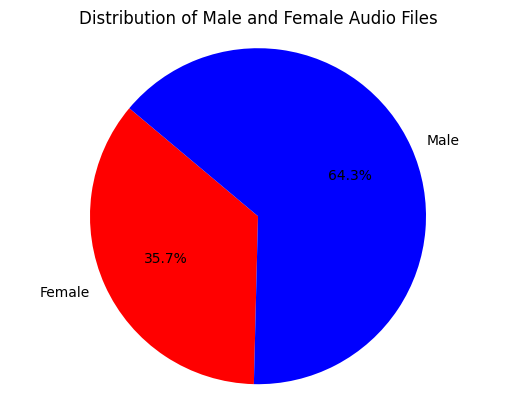

In [8]:
#piplot to show distribution of male and female files


import matplotlib.pyplot as plt
labels = ['Female', 'Male']
sizes = [len(female_path), len(male_path)]
colors = ['red','blue']


plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Distribution of Male and Female Audio Files')
plt.show()

In [9]:
file_paths[100]#Showing 100th file path

'C:\\Cp2\\Cp2 New\\Voicegender\\data\\female\\arctic_a0015(4).wav'

In [10]:
#play audio file of one female, one male file path
print('Femaile Audio Sample:')
ipd.Audio(file_paths[0])



Femaile Audio Sample:


In [12]:
print('\nMale Audio Sample:')
ipd.Audio(file_paths[-1])


Male Audio Sample:


In [22]:
# #copying file paths to a dataframe  with column as audio


df_audio=pd.DataFrame(file_paths,columns=['audio'])


import os

# Extract gender from the folder name and create label column
df_audio['label'] = df_audio['audio'].apply(lambda x: os.path.basename(os.path.dirname(x)))

In [23]:
df_audio.head()

,audio,label
0,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female
1,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female
2,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female
3,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female
4,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female


1. Load audio file waves and audio, spectrogram

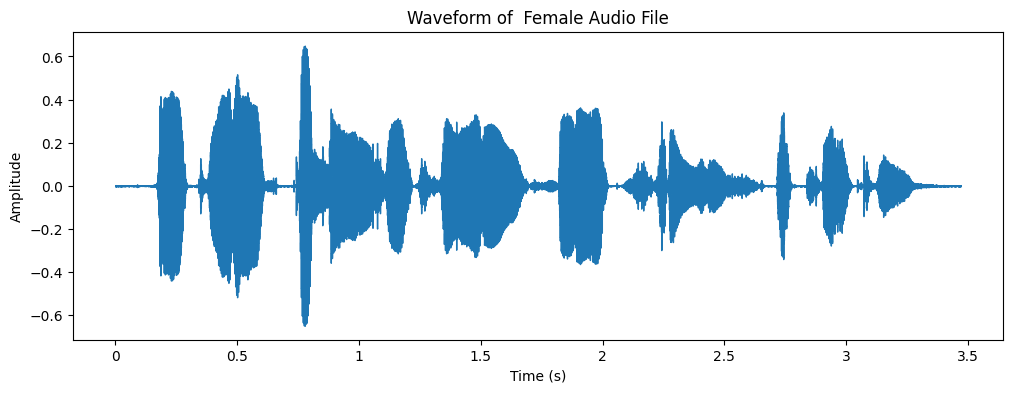

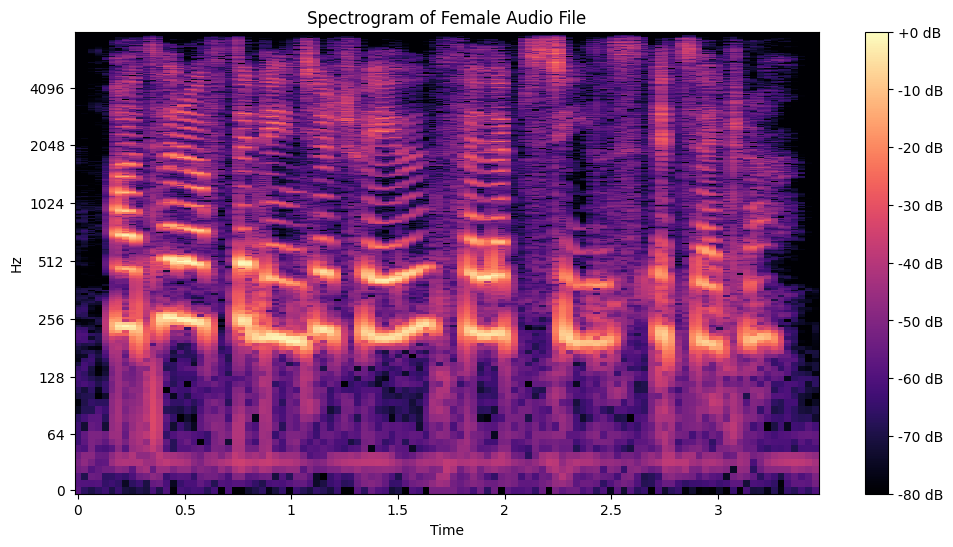

In [24]:

#plot waveform of female audio file and spectrogram and play audio


import librosa.display
plt.figure(figsize=(12, 4))
y, sr = librosa.load(df_audio.iloc[0, 0], sr=None)
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform of  Female Audio File')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()



#Plot Spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.figure(figsize=(12, 6))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of Female Audio File')
plt.show()

ipd.Audio(df_audio.iloc[0, 0]) # Play Audio


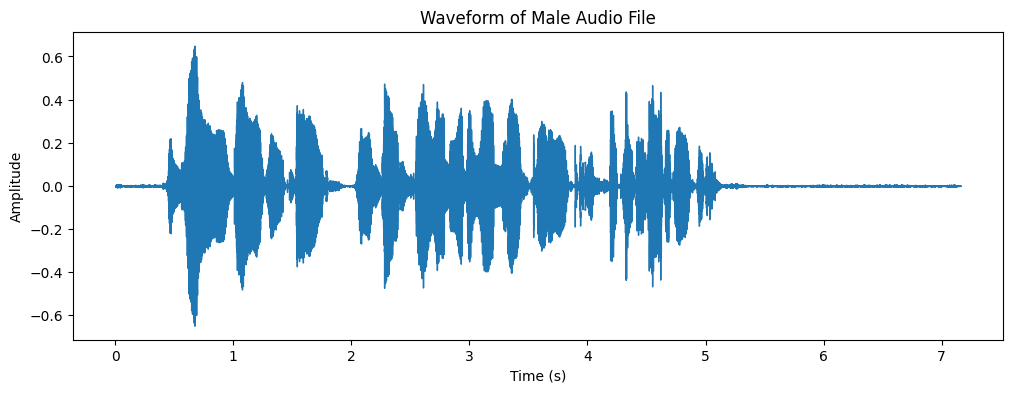

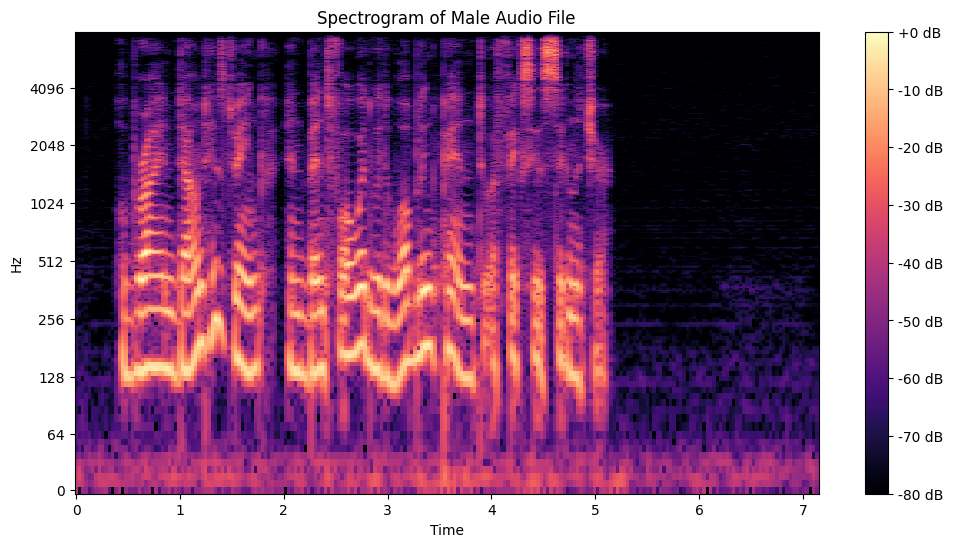

In [25]:
#plot waveform of male audio file and spectrogram and play audio


plt.figure(figsize=(12, 4)) 
y, sr = librosa.load(df_audio.iloc[-1, 0], sr=None)
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform of Male Audio File')
plt.xlabel('Time (s)')      
plt.ylabel('Amplitude')
plt.show()


#Plot Spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.figure(figsize=(12, 6)) 
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')    
plt.title('Spectrogram of Male Audio File')
plt.show()  


ipd.Audio(df_audio.iloc[-1, 0]) # Play Audio

In [26]:
#Observations:
# The female audio file has a higher pitch and frequency range compared to the male audio file.
#  This is evident from the waveform and spectrogram plots, where the female audio shows more rapid oscillations and a broader frequency distribution.
# The male audio file has a lower pitch and a narrower frequency range, with slower oscillations in the waveform and concentrated energy in the lower frequencies in the spectrogram. 
#
# These differences in pitch and frequency characteristics are typical between male and female voices.

In [19]:
#Determine max and min duration of audio files
import librosa

durations = []

for audio in file_paths:
    y, sr = librosa.load(audio, sr=None)
    durations.append(len(y) / sr)

print("Max duration:", max(durations))
print("Min duration:", min(durations))


Max duration: 9.69
Min duration: 0.925


1. Audio preprosessing with df_audio dataframe

1. . Trim Silence
Removes unnecessary silence from the beginning and end of the audio. This helps eliminate parts of the audio that contain no useful information.

We use librosa.effects.trim() function with a parameter top_db which stands for "how many decibels below the peak" should be considered silence.

"Decibels" is a logarithmic unit used to measure sound level.

Lower top_db (e.g., 20)  stricter silence removal (only trims very quiet parts).
Higher top_db (e.g., 60) more aggressive (trims even moderately quiet parts).

We will choose 35 which is somewhat in the middle

In [30]:
import numpy as np

col = df_audio['audio']
print(type(col))                # pandas Series
print(col.dtype)                # likely 'object' if problematic
print(type(col.iloc[0]))        # inspect one cell
print(np.shape(col.iloc[0])) 

<class 'pandas.core.series.Series'>
object
<class 'str'>
()


In [31]:
#1. Trimming the wave start end silence supressing make only unsilenced wave

import os
from pathlib import Path
import librosa
import soundfile as sf   # pip install soundfile
import pandas as pd
from tqdm.auto import tqdm  # optional progress bar

# params
TOP_DB = 25            # how aggressive trimming is (20-30 is common) if it is higher become agressive triimg
TARGET_SR = None       # 16000 to resample everything; None to keep original
OUT_DIR = Path("trimmed_audio")
OUT_DIR.mkdir(exist_ok=True)

def trim_from_path(path_str, top_db=25, target_sr=TARGET_SR, save_trimmed=True, out_dir=OUT_DIR):
    """Loads audio from a file path, trims leading/trailing silence, optionally saves trimmed wav.
    Returns (trimmed_audio_array, sr, interval_samples, out_path_or_None)"""
    # defensive: if path is a pandas NA or empty string, return None
    if not path_str or pd.isna(path_str):
        return None, None, None, None

    # load; librosa.load returns float32 by default in range [-1, 1]
    y, sr = librosa.load(path_str, sr=target_sr, mono=True)
    trimmed_y, intervals = librosa.effects.trim(y, top_db=top_db)
    out_path = None
    if save_trimmed and trimmed_y.size > 0:
        fname = Path(path_str).stem + "_trimmed.wav"
        out_path = out_dir / fname
        sf.write(str(out_path), trimmed_y, sr, subtype='PCM_16')  # or float32 if you prefer
    return trimmed_y, sr, intervals, str(out_path) if out_path else None


# Apply to dataframe column (safe, with progress and error handling)
trimmed_audio = []
sr_list = []
intervals_list = []
out_paths = []

for i, p in enumerate(tqdm(df_audio['audio'], desc="Trimming audio")):
    try:
        trimmed_y, sr, intervals, out_path = trim_from_path(p)
    except Exception as e:
        # record failure; we can log or print more info
        trimmed_y, sr, intervals, out_path = None, None, None, None
        print(f"Error trimming row {i} ({p}): {e}")
    trimmed_audio.append(trimmed_y)
    sr_list.append(sr)
    intervals_list.append(intervals)
    out_paths.append(out_path)

# Attach back to dataframe
df_audio = df_audio.copy()
df_audio['trimmed_audio'] = trimmed_audio
df_audio['sr'] = sr_list
df_audio['trim_intervals'] = intervals_list
df_audio['trimmed_path'] = out_paths

# Quick inspection
print(df_audio[['audio','sr','trim_intervals','trimmed_path']].head())


Trimming audio:   0%|          | 0/16148 [00:00<?, ?it/s]

                                               audio  ...                               trimmed_path
0  C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...  ...  trimmed_audio\arctic_a0001(1)_trimmed.wav
1  C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...  ...  trimmed_audio\arctic_a0001(3)_trimmed.wav
2  C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...  ...  trimmed_audio\arctic_a0001(4)_trimmed.wav
3  C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...  ...  trimmed_audio\arctic_a0001(5)_trimmed.wav
4  C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...  ...  trimmed_audio\arctic_a0001(6)_trimmed.wav

[5 rows x 4 columns]


In [32]:
df_audio.head()

,audio,label,trimmed_audio,sr,trim_intervals,trimmed_path
0,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,"[-0.00015258789, -6.1035156e-05, -6.1035156e-0...",16000,"[2048, 53248]",trimmed_audio\arctic_a0001(1)_trimmed.wav
1,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,"[-0.0051879883, -0.0046691895, -0.004272461, -...",16000,"[512, 46592]",trimmed_audio\arctic_a0001(3)_trimmed.wav
2,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,"[-0.0008544922, -0.0010681152, -0.00079345703,...",16000,"[2560, 46592]",trimmed_audio\arctic_a0001(4)_trimmed.wav
3,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,"[0.0009765625, 0.00061035156, 0.0002746582, 0....",16000,"[16384, 69632]",trimmed_audio\arctic_a0001(5)_trimmed.wav
4,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,"[-0.00030517578, -0.00076293945, -0.0010375977...",16000,"[2048, 50688]",trimmed_audio\arctic_a0001(6)_trimmed.wav


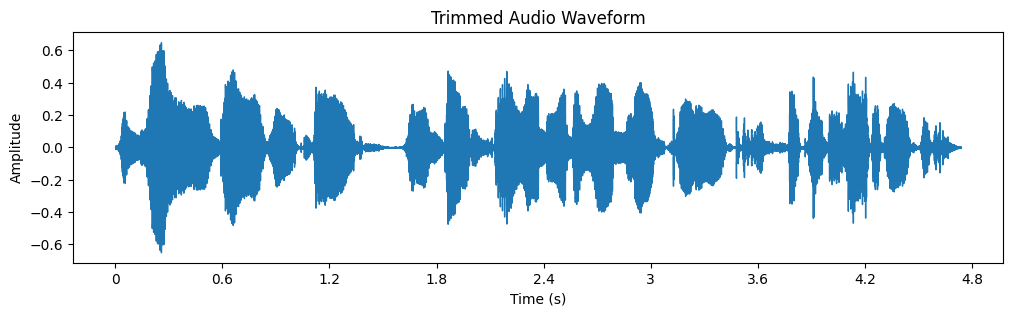

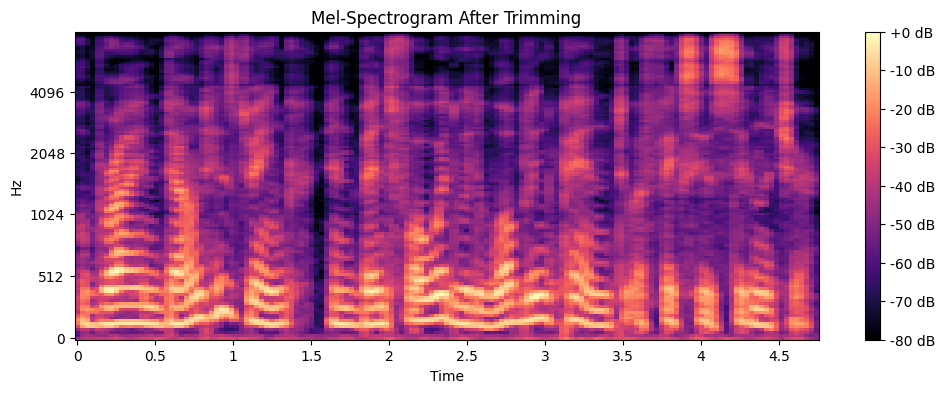

In [39]:
#See the waveform and spectrograme and audio after strimming
import matplotlib.pyplot as plt
import librosa
import librosa.display# Used for listen the audio

# pick audio based on index to visualize
i = -1
y = df_audio['trimmed_audio'].iloc[i]
sr = df_audio['sr'].iloc[i]

plt.figure(figsize=(12, 3))
librosa.display.waveshow(y, sr=sr)
plt.title("Trimmed Audio Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


#See the spectrograme after trimming
plt.figure(figsize=(12, 4))

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_db = librosa.power_to_db(S, ref=np.max)

librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel-Spectrogram After Trimming")
plt.show()


#Listen the voice after trimming
import IPython.display as ipd
ipd.Audio(y, rate=sr)


#After trimming trailing slilnce we got trimmed audio files with less time


In [40]:
#2. Normalization: Ensure audio levels are consistent across files.

#Use trimmed_audio
import numpy as np

def peak_normalize(y, target_peak=0.99):
    y = np.asarray(y, dtype=np.float32)
    max_val = np.max(np.abs(y)) if y.size else 0.0
    if max_val == 0:
        return y
    scale = target_peak / max_val
    y_norm = y * scale
    np.clip(y_norm, -1.0, 1.0, out=y_norm)
    return y_norm

#Apply to all audio

from pathlib import Path
import soundfile as sf

OUT_DIR = Path("peak_normalized_audio")
OUT_DIR.mkdir(exist_ok=True)

norm_list = []
norm_path_list = []

for i, row in df_audio.iterrows():
    y = row['trimmed_audio']       # THIS is the correct y
    sr = row['sr']

    if y is None:
        norm_list.append(None)
        norm_path_list.append(None)
        continue

    y_norm = peak_normalize(y)

    file_name = Path(row['audio']).stem + "_peaknorm.wav"
    out_path = OUT_DIR / file_name
    sf.write(str(out_path), y_norm, sr, subtype='PCM_16')

    norm_list.append(y_norm)
    norm_path_list.append(str(out_path))

df_audio["normalized_audio"] = norm_list
df_audio["normalized_path"] = norm_path_list




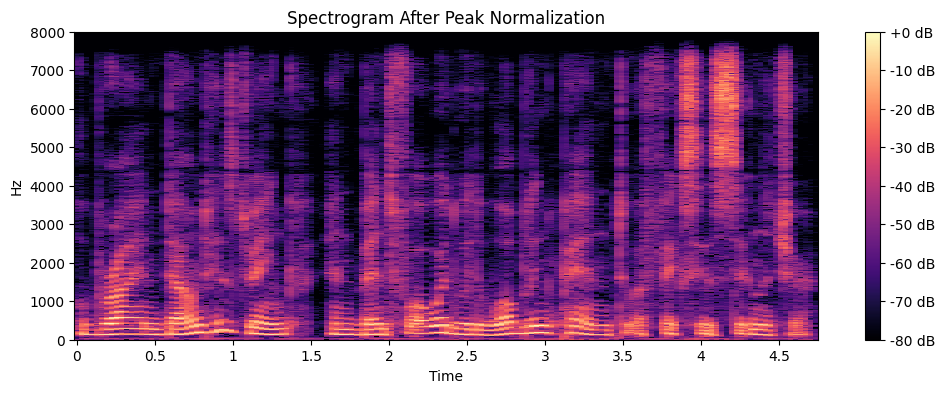

In [42]:
#Spectrograme after Normalization
plt.figure(figsize=(12, 4))

S = librosa.amplitude_to_db(
        np.abs(librosa.stft(y_norm)),
        ref=np.max
    )

librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram After Peak Normalization")
plt.show()


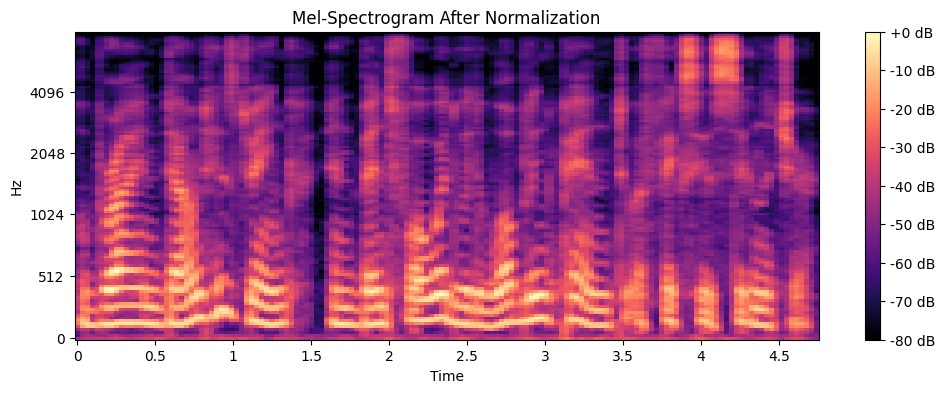

In [43]:
#Generate Mel-Spectrogram (CNN-ready)
S = librosa.feature.melspectrogram(
        y=y_norm, sr=sr, 
        n_mels=128,
        fmax=8000
    )

S_db = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel-Spectrogram After Normalization")
plt.show()


3. Re sampling

In [47]:
df_audio['sr'].value_counts()

sr
16000    16148
Name: count, dtype: int64

we can safely skip resampling.

I already have a clean, uniform dataset at 16 kHz, which is the best standard for speech models.

4.Padding/Truncating: Ensure all inputs have the same length.

Check Durations of All Audio Clips

Use trimmed + normalized audio (best quality).
If we  don’t have normalized_audio, use trimmed_audio.

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Choose which waveform column to check
if 'normalized_audio' in df_audio.columns:
    wave_col = 'normalized_audio'
else:
    wave_col = 'trimmed_audio'

print("Using column:", wave_col)

# Get sample rate (all are 16000 as you confirmed)
sr = df_audio['sr'].mode()[0]   # should be 16000
print("Sample rate:", sr)

# Compute durations in seconds
durations = df_audio[wave_col].apply(lambda x: len(x)/sr if isinstance(x, np.ndarray) else np.nan)
df_audio['duration_s'] = durations

# Show stats
print("\n=== Duration Statistics (seconds) ===")
print(durations.describe())


Using column: normalized_audio
Sample rate: 16000

=== Duration Statistics (seconds) ===
count    16148.000000
mean         2.851138
std          0.859940
min          0.704000
25%          2.240000
50%          2.816000
75%          3.392000
max          7.122000
Name: normalized_audio, dtype: float64


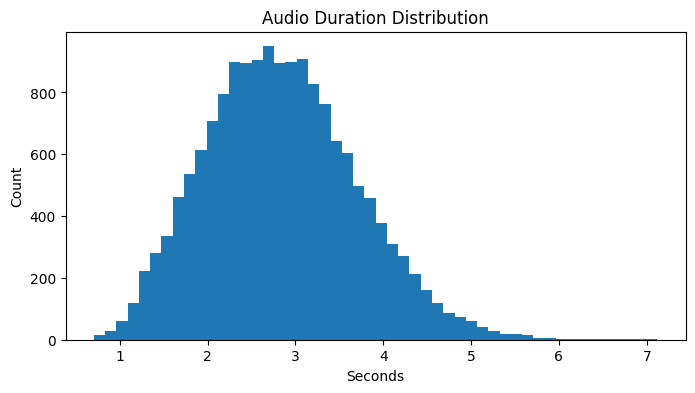

In [50]:
#Audio duration duration
plt.figure(figsize=(8,4))
plt.hist(durations.dropna(), bins=50)
plt.title("Audio Duration Distribution")
plt.xlabel("Seconds")
plt.ylabel("Count")
plt.show()

4. Padding/Truncating: Ensure all inputs have the same length.

In [51]:
#Checkfor the durations
durations = df_audio['duration_s']
short_pct = (durations < (30000/16000)).mean() * 100
long_pct = (durations > (30000/16000)).mean() * 100

print("Percent shorter than 1.875 sec:", short_pct)
print("Percent longer than 1.875 sec:", long_pct)


Percent shorter than 1.875 sec: 12.825117661629923
Percent longer than 1.875 sec: 87.1686896210057


But Idont want to change the file originalty in case of padding and its sensitiveness, will train the cnn model wich can handle without that padding here, cause we dont have  heavy duration files mean

In [52]:
df_audio.head()

,audio,label,trimmed_audio,sr,trim_intervals,trimmed_path,normalized_audio,normalized_path,duration_s
0,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,"[-0.00015258789, -6.1035156e-05, -6.1035156e-0...",16000,"[2048, 53248]",trimmed_audio\arctic_a0001(1)_trimmed.wav,"[-0.00023241619, -9.2966475e-05, -9.2966475e-0...",peak_normalized_audio\arctic_a0001(1)_peaknorm...,3.200
1,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,"[-0.0051879883, -0.0046691895, -0.004272461, -...",16000,"[512, 46592]",trimmed_audio\arctic_a0001(3)_trimmed.wav,"[-0.00790215, -0.0071119354, -0.0065076533, -0...",peak_normalized_audio\arctic_a0001(3)_peaknorm...,2.880
2,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,"[-0.0008544922, -0.0010681152, -0.00079345703,...",16000,"[2560, 46592]",trimmed_audio\arctic_a0001(4)_trimmed.wav,"[-0.0013015306, -0.0016269133, -0.0012085642, ...",peak_normalized_audio\arctic_a0001(4)_peaknorm...,2.752
3,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,"[0.0009765625, 0.00061035156, 0.0002746582, 0....",16000,"[16384, 69632]",trimmed_audio\arctic_a0001(5)_trimmed.wav,"[0.0014874636, 0.00092966476, 0.00041834914, 0...",peak_normalized_audio\arctic_a0001(5)_peaknorm...,3.328
4,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,"[-0.00030517578, -0.00076293945, -0.0010375977...",16000,"[2048, 50688]",trimmed_audio\arctic_a0001(6)_trimmed.wav,"[-0.00046483238, -0.0011620809, -0.0015804301,...",peak_normalized_audio\arctic_a0001(6)_peaknorm...,3.040


Feature Extraction Without Padding

In [67]:
y = df_audio['normalized_audio'].iloc[i]



import numpy as np
import librosa

def extract_features(y, sr):
    # 1. MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)

    # 2. Spectral Centroid
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)

    # 3. Spectral Rolloff
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)

    # 4. Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)

    # 5. RMS
    rms = librosa.feature.rms(y=y)

    # Combine (24, T)
    features = np.vstack([mfcc, centroid, rolloff, zcr, rms])
    return features


# Apply to all files
all_features = []
for idx, row in df_audio.iterrows():
    y = row['normalized_audio']   # waveform array
    sr = row['sr']                # sample rate

    if y is None:
        all_features.append(None)
        continue

    feats = extract_features(np.asarray(y, dtype=np.float32), sr)
    all_features.append(feats)

df_audio['features'] = all_features


In [68]:
df_audio['features'].apply(lambda x: x.shape if x is not None else None).head()


0    (24, 101)
1     (24, 91)
2     (24, 87)
3    (24, 105)
4     (24, 96)
Name: features, dtype: object

In [70]:
df_audio.head()

,audio,label,trimmed_audio,sr,trim_intervals,trimmed_path,normalized_audio,normalized_path,duration_s,features
0,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,"[-0.00015258789, -6.1035156e-05, -6.1035156e-0...",16000,"[2048, 53248]",trimmed_audio\arctic_a0001(1)_trimmed.wav,"[-0.00023241619, -9.2966475e-05, -9.2966475e-0...",peak_normalized_audio\arctic_a0001(1)_peaknorm...,3.200,"[[-368.973876953125, -125.4857177734375, -63.5..."
1,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,"[-0.0051879883, -0.0046691895, -0.004272461, -...",16000,"[512, 46592]",trimmed_audio\arctic_a0001(3)_trimmed.wav,"[-0.00790215, -0.0071119354, -0.0065076533, -0...",peak_normalized_audio\arctic_a0001(3)_peaknorm...,2.880,"[[-293.8697509765625, -99.89112854003906, -28...."
2,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,"[-0.0008544922, -0.0010681152, -0.00079345703,...",16000,"[2560, 46592]",trimmed_audio\arctic_a0001(4)_trimmed.wav,"[-0.0013015306, -0.0016269133, -0.0012085642, ...",peak_normalized_audio\arctic_a0001(4)_peaknorm...,2.752,"[[-175.8643798828125, -75.14910888671875, -84...."
3,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,"[0.0009765625, 0.00061035156, 0.0002746582, 0....",16000,"[16384, 69632]",trimmed_audio\arctic_a0001(5)_trimmed.wav,"[0.0014874636, 0.00092966476, 0.00041834914, 0...",peak_normalized_audio\arctic_a0001(5)_peaknorm...,3.328,"[[-499.0735778808594, -207.4949188232422, -85...."
4,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,"[-0.00030517578, -0.00076293945, -0.0010375977...",16000,"[2048, 50688]",trimmed_audio\arctic_a0001(6)_trimmed.wav,"[-0.00046483238, -0.0011620809, -0.0015804301,...",peak_normalized_audio\arctic_a0001(6)_peaknorm...,3.040,"[[-367.5951843261719, -164.9076385498047, -87...."


In [80]:
# Find maximum time dimension
max_T = max(f.shape[1] for f in df_audio['features'])
max_T

223

In [81]:
#Padd all features with max_time
import numpy as np

def pad_features(f, max_T):
    T = f.shape[1]
    if T == max_T:
        return f
    # pad on right side
    pad_width = max_T - T
    return np.pad(f, ((0,0), (0, pad_width)), mode='constant')


In [82]:
#Apply padding

X = []
for f in df_audio['features']:
    X.append(pad_features(f, max_T))

X = np.array(X)   # NOW it works
X = np.expand_dims(X, -1)   # CNN expects (samples, 24, T, 1)


In [83]:
y = df_audio['label'].apply(lambda x: 1 if x=="male" else 0).values

In [84]:
#Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [85]:
X_train.shape, X_test.shape

((12918, 24, 223, 1), (3230, 24, 223, 1))

In [86]:
X_train

array([[[[-3.94335724e+02],
         [-1.90101715e+02],
         [-9.58591461e+01],
         ...,
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00]],

        [[ 1.22838081e+02],
         [ 1.30583084e+02],
         [ 1.07222382e+02],
         ...,
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00]],

        [[ 2.28004265e+01],
         [-4.14732170e+01],
         [-4.56496124e+01],
         ...,
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00]],

        ...,

        [[ 1.29687500e+03],
         [ 2.45312500e+03],
         [ 2.58593750e+03],
         ...,
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00]],

        [[ 1.56250000e-02],
         [ 3.51562500e-02],
         [ 4.63867188e-02],
         ...,
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00]],

        [[ 6.12444915e-02],
         [ 1.33603692e-01],
         [

Build the CNN model

In [87]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(24, max_T, 1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 223, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 111, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 111, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 55, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21120)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,351,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,370,625 (5.23 MB)

 Trainable params: 1,370,625 (5.23 MB)

 Non-trainable params: 0 (0.00 B)

TRAIN THE MODEL

In [88]:
history = model.fit(X_train, y_train,validation_split=0.2,epochs=10,batch_size=32)


Epoch 1/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 47s 117ms/step - accuracy: 0.7344 - loss: 8.0588 - val_accuracy: 0.9361 - val_loss: 0.1864
Epoch 2/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 33s 101ms/step - accuracy: 0.9410 - loss: 0.1504 - val_accuracy: 0.9570 - val_loss: 0.1194
Epoch 3/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 38s 119ms/step - accuracy: 0.9647 - loss: 0.0914 - val_accuracy: 0.9466 - val_loss: 0.1515
Epoch 4/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 38s 117ms/step - accuracy: 0.9762 - loss: 0.0683 - val_accuracy: 0.9687 - val_loss: 0.0915
Epoch 5/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 36s 111ms/step - accuracy: 0.9743 - loss: 0.0632 - val_accuracy: 0.9702 - val_loss: 0.0765
Epoch 6/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 36s 112ms/step - accuracy: 0.9809 - loss: 0.0493 - val_accuracy: 0.9532 - val_loss: 0.1310
Epoch 7/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 36s 111ms/step - accuracy: 0.9822 - loss: 0.0456 - val_accuracy: 0.9555 - val_loss: 0.1299
Epoch 8/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 41s 126ms/step - accuracy: 0.9895 - loss: 0

Evaluate

In [ ]:
model.evaluate(X_test, y_test)



101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9817 - loss: 0.0628


[0.06277288496494293, 0.9817337393760681]

Predict:

In [91]:
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)



# Classification report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['male','female']))




--- Classification Report ---
              precision    recall  f1-score   support

        male       0.36      1.00      0.53      1154
      female       0.00      0.00      0.00      2076

    accuracy                           0.36      3230
   macro avg       0.18      0.50      0.26      3230
weighted avg       0.13      0.36      0.19      3230



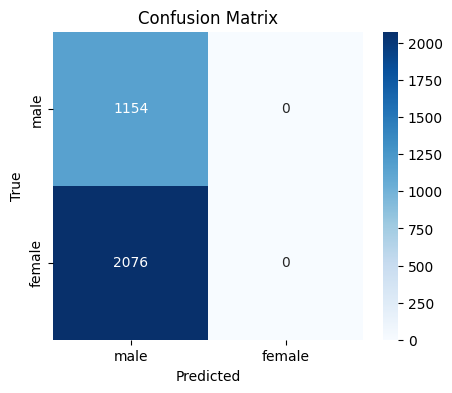

In [92]:

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['male','female'], yticklabels=['male','female'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

plot training curves

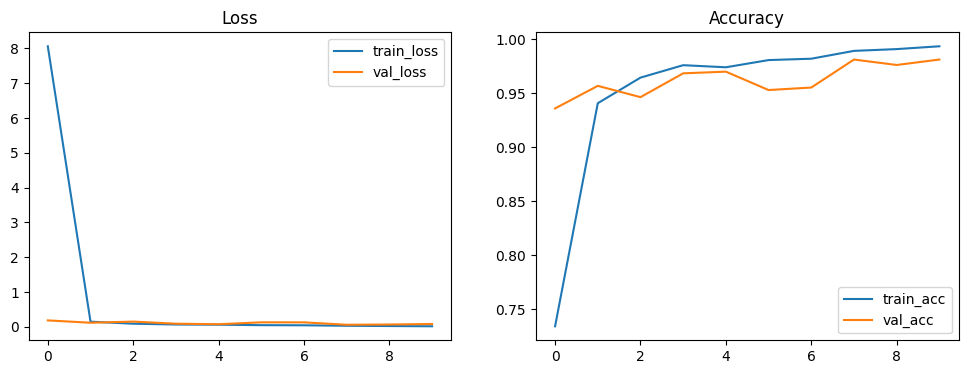

In [94]:

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()

In [42]:
# --------------------------------------------------------------------------------------------------------------

#Part-2: Convert Speech to Text (STT)

Since our dataset contains audio files, we need a vocks small model

In [101]:
df_audio['normalized_path'].head()

0    peak_normalized_audio\arctic_a0001(1)_peaknorm...
1    peak_normalized_audio\arctic_a0001(3)_peaknorm...
2    peak_normalized_audio\arctic_a0001(4)_peaknorm...
3    peak_normalized_audio\arctic_a0001(5)_peaknorm...
4    peak_normalized_audio\arctic_a0001(6)_peaknorm...
Name: normalized_path, dtype: object

For speech-to-text conversion (Voice To Text):

I Use audio/normalized_path

This will gives the cleanest, most accurate transcription.

1. It is cleaned audio
2. Silence removed
3. Peak normalized (volume consistent)
4. Stored as a proper .wav file
5. Ready for Whisper or Wav2Vec or SpeechRecognition, Butwhisper is not needed always normalized version it is robust
6. ASR models expect a file path or waveform with proper amplitude scaling


If i use any other insted of normalized_path. 
Like-

audio– it is raw file paths (okay but not cleaned)

trimmed_audio– Python list of floats, it isnot ideal for ASR

normalized_audio– ndarray of floats, so ASR models prefer file input

features– This is for classification, not ASR, And cannot be used for speech-to-text

In [107]:
import os

path = df_audio['normalized_path'].iloc[0]
print(path)
print(os.path.exists(path))

c:\Cp2\Cp2 New\Voicegender\peak_normalized_audio\arctic_a0001(1)_peaknorm.wav
True


In [110]:
%pip install transformers
%pip install librosa
%pip install torch

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   ---- ----------------------------------- 1.3/12.0 MB 9.1 MB/s eta 0:00:02
   --------- ------------------------------ 2.9/12.0 MB 7.0 MB/s eta 0:00:02
   ------------- -------------------------- 3.9/12.0 MB 7.0 MB/s eta 0:00:02
   ----------------- ---------------------- 5.2/12.0 MB 6.4 MB/s eta 0:00:02
   ----------------------- ---------------- 7.1/12.0 MB 6.7 MB/s eta 0:00:01
   ---------------------------- ----------- 8.7/12.0 MB 6.9 MB/s eta 0:00:01
   ------------------------------- -------- 9.4/12.0 MB 6.4 MB/s eta 0:00:01
   ---------------------------------- ----- 10.2/12.0 MB 6.2 MB/s eta 0:00:01
   ------------------------------------- -- 11.3/12.0 MB 6.0 MB/s eta 0:00:01
   ---------------------------------------  11.8/12.0 MB 6.1 MB/s eta 0:00:01
   ---------------------------------------- 12.0/12.0 MB 5.2 MB/s  0:00:02
   -

In [152]:
df_audio['normalized_path'].iloc[0] #Check normalized_path of 0 index

'c:\\Cp2\\Cp2 New\\Voicegender\\peak_normalized_audio\\arctic_a0001(1)_peaknorm.wav'

In [ ]:
#-------------------------

In [126]:
%pip install tf-keras

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 7.6 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [127]:
import tf_keras as keras

In [ ]:
print(df_audio["normalized_path"].iloc[0])
print(os.path.exists(df_audio["normalized_path"].iloc[0]))#Checkfor existence

c:\Cp2\Cp2 New\Voicegender\peak_normalized_audio\arctic_a0001(1)_peaknorm.wav
True


In [133]:
%pip install vosk SpeechRecognition

Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/14.0 MB ? eta -:--:--
   ----- ---------------------------------- 1.8/14.0 MB 10.1 MB/s eta 0:00:02
   ----------- ---------------------------- 3.9/14.0 MB 9.4 MB/s eta 0:00:02
   ---------------- ----------------------- 5.8/14.0 MB 9.3 MB/s eta 0:00:01
   --------------------- ------------------ 7.6/14.0 MB 9.3 MB/s eta 0:00:01
   -------------------------- ------------- 9.4/14.0 MB 9.1 MB/s eta 0:00:01
   -------------------------------- ------- 11.3/14.0 MB 9.1 MB/s eta 0:00:01
   ------------------------------------- -- 13.1/14.0 MB 9

In [135]:
%pip install SpeechRecognition

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Vosk Offline Transcription Code

In [140]:
import wave
import json
from vosk import Model, KaldiRecognizer

# === 1. Load the offline VOSK model === 
vosk_model_path = r"C:\Cp2\Cp2 New\Voicegender\vosk-model-small-en-us-0.15\vosk-model-small-en-us-0.15"
model = Model(vosk_model_path)

# === 2. Function for offline transcription ===
def transcribe_vosk(audio_path):
    wf = wave.open(audio_path, "rb")
    
    # Verify format
    if wf.getnchannels() != 1 or wf.getsampwidth() != 2:
        return "[Unsupported WAV Format]"

    rec = KaldiRecognizer(model, wf.getframerate())
    text = ""

    while True:
        data = wf.readframes(4000)
        if len(data) == 0:
            break
        if rec.AcceptWaveform(data):
            result = json.loads(rec.Result())
            text += " " + result.get("text", "")
    
    final_res = json.loads(rec.FinalResult())
    text += " " + final_res.get("text", "")

    return text.strip()


In [146]:
# #Apply on all files
# df_audio['transcription'] = df_audio['normalized_path'].apply(transcribe_vosk)


#It is taking time for around 13 Hours to complet so i will apply it on 1000 random files

In [143]:
from pathlib import Path

vosk_model_dir = Path(r"C:\Cp2\Cp2 New\Voicegender\vosk-model-small-en-us-0.15\vosk-model-small-en-us-0.15")
print("Model dir:", vosk_model_dir)
print("Exists:", vosk_model_dir.exists())

# Check for some expected files inside (e.g., 'model.conf' or 'ivector' or 'rescore' may vary)
print("List top-level files:", list(vosk_model_dir.iterdir())[:10])



Model dir: C:\Cp2\Cp2 New\Voicegender\vosk-model-small-en-us-0.15\vosk-model-small-en-us-0.15
Exists: True
List top-level files: [WindowsPath('C:/Cp2/Cp2 New/Voicegender/vosk-model-small-en-us-0.15/vosk-model-small-en-us-0.15/am'), WindowsPath('C:/Cp2/Cp2 New/Voicegender/vosk-model-small-en-us-0.15/vosk-model-small-en-us-0.15/conf'), WindowsPath('C:/Cp2/Cp2 New/Voicegender/vosk-model-small-en-us-0.15/vosk-model-small-en-us-0.15/graph'), WindowsPath('C:/Cp2/Cp2 New/Voicegender/vosk-model-small-en-us-0.15/vosk-model-small-en-us-0.15/ivector'), WindowsPath('C:/Cp2/Cp2 New/Voicegender/vosk-model-small-en-us-0.15/vosk-model-small-en-us-0.15/README')]


In [144]:
%pip install vosk soundfile tqdm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [149]:
texts = []
for i, path in enumerate(df_audio['normalized_path'][:1000]):
    t = transcribe_vosk_file(path, model)
    texts.append(t)
    if i % 50 == 0:
        print("done", i)
df_audio.loc[:999, 'transcription'] = texts
df_audio.loc[:999].to_csv("transcriptions_partial_simple.csv", index=False)


done 0
done 50
done 100
done 150
done 200
done 250
done 300
done 350
done 400
done 450
done 500
done 550
done 600
done 650
done 700
done 750
done 800
done 850
done 900
done 950


In [157]:
#Read the transcripted file
df_transcripted_partial=pd.read_csv(r"C:\Cp2\Cp2 New\Voicegender\transcriptions_partial_simple.csv")

df_transcripted_partial.head()

,audio,label,trimmed_audio,sr,trim_intervals,trimmed_path,normalized_audio,normalized_path,duration_s,features,label_num,audio_abs,transcription
0,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,[-1.5258789e-04 -6.1035156e-05 -6.1035156e-05 ...,16000,[ 2048 53248],trimmed_audio\arctic_a0001(1)_trimmed.wav,[-2.3241619e-04 -9.2966475e-05 -9.2966475e-05 ...,c:\Cp2\Cp2 New\Voicegender\peak_normalized_aud...,3.200,[[-3.68973877e+02 -1.25485718e+02 -6.35649223e...,0,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,author of the danger trail philip steals etc
1,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,[-0.00518799 -0.00466919 -0.00427246 ... 0.00...,16000,[ 512 46592],trimmed_audio\arctic_a0001(3)_trimmed.wav,[-0.00790215 -0.00711194 -0.00650765 ... 0.00...,c:\Cp2\Cp2 New\Voicegender\peak_normalized_aud...,2.880,[[-2.93869751e+02 -9.98911285e+01 -2.83664532e...,0,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,author of the range of trail philip steals etc
2,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,[-0.00085449 -0.00106812 -0.00079346 ... -0.00...,16000,[ 2560 46592],trimmed_audio\arctic_a0001(4)_trimmed.wav,[-0.00130153 -0.00162691 -0.00120856 ... -0.00...,c:\Cp2\Cp2 New\Voicegender\peak_normalized_aud...,2.752,[[-1.75864380e+02 -7.51491089e+01 -8.43130188e...,0,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,author of the danger trail philip steals etc
3,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,[ 0.00097656 0.00061035 0.00027466 ... 0.00...,16000,[16384 69632],trimmed_audio\arctic_a0001(5)_trimmed.wav,[ 0.00148746 0.00092966 0.00041835 ... 0.00...,c:\Cp2\Cp2 New\Voicegender\peak_normalized_aud...,3.328,[[-4.99073578e+02 -2.07494919e+02 -8.53346024e...,0,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,author of the danger trill philip steals etc
4,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,[-0.00030518 -0.00076294 -0.0010376 ... 0.01...,16000,[ 2048 50688],trimmed_audio\arctic_a0001(6)_trimmed.wav,[-0.00046483 -0.00116208 -0.00158043 ... 0.01...,c:\Cp2\Cp2 New\Voicegender\peak_normalized_aud...,3.040,[[-3.67595184e+02 -1.64907639e+02 -8.79865417e...,0,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,author of the danger trail philip steals etc


In [153]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------

Part 3: NLP and processing the transcripted audios to clean text

we already finished:

Part 1:

1.Audio trimming

2. Normalization

3. Feature extraction

4. CNN speech gender classification

Part 2:

5. Offline transcription (first 1000 files processing)

Basic NLP Cleanup

After transcription, text may have:

Noise

Wrong spellings

Empty sentences

Extra whitespace


1. Use a simple cleaning function:

In [2]:
#Load the transcripted file csv for NLP operation
import pandas as pd

df = pd.read_csv(r"C:\Cp2\Cp2 New\Voicegender\transcriptions_partial_simple.csv")
df.head()

,audio,label,trimmed_audio,sr,trim_intervals,trimmed_path,normalized_audio,normalized_path,duration_s,features,label_num,audio_abs,transcription
0,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,[-1.5258789e-04 -6.1035156e-05 -6.1035156e-05 ...,16000,[ 2048 53248],trimmed_audio\arctic_a0001(1)_trimmed.wav,[-2.3241619e-04 -9.2966475e-05 -9.2966475e-05 ...,c:\Cp2\Cp2 New\Voicegender\peak_normalized_aud...,3.200,[[-3.68973877e+02 -1.25485718e+02 -6.35649223e...,0,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,author of the danger trail philip steals etc
1,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,[-0.00518799 -0.00466919 -0.00427246 ... 0.00...,16000,[ 512 46592],trimmed_audio\arctic_a0001(3)_trimmed.wav,[-0.00790215 -0.00711194 -0.00650765 ... 0.00...,c:\Cp2\Cp2 New\Voicegender\peak_normalized_aud...,2.880,[[-2.93869751e+02 -9.98911285e+01 -2.83664532e...,0,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,author of the range of trail philip steals etc
2,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,[-0.00085449 -0.00106812 -0.00079346 ... -0.00...,16000,[ 2560 46592],trimmed_audio\arctic_a0001(4)_trimmed.wav,[-0.00130153 -0.00162691 -0.00120856 ... -0.00...,c:\Cp2\Cp2 New\Voicegender\peak_normalized_aud...,2.752,[[-1.75864380e+02 -7.51491089e+01 -8.43130188e...,0,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,author of the danger trail philip steals etc
3,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,[ 0.00097656 0.00061035 0.00027466 ... 0.00...,16000,[16384 69632],trimmed_audio\arctic_a0001(5)_trimmed.wav,[ 0.00148746 0.00092966 0.00041835 ... 0.00...,c:\Cp2\Cp2 New\Voicegender\peak_normalized_aud...,3.328,[[-4.99073578e+02 -2.07494919e+02 -8.53346024e...,0,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,author of the danger trill philip steals etc
4,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,[-0.00030518 -0.00076294 -0.0010376 ... 0.01...,16000,[ 2048 50688],trimmed_audio\arctic_a0001(6)_trimmed.wav,[-0.00046483 -0.00116208 -0.00158043 ... 0.01...,c:\Cp2\Cp2 New\Voicegender\peak_normalized_aud...,3.040,[[-3.67595184e+02 -1.64907639e+02 -8.79865417e...,0,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,author of the danger trail philip steals etc


1. Basic Cleaning Function


We will remove:Lowercase conversion, Punctuation, Numbers, Extra spaces

In [3]:
import re

def clean_text(text):
    if text is None or str(text).strip() == "":
        return ""
    
    text = text.lower()                                   # lowercase
    text = re.sub(r"[^a-zA-Z\s]", "", text)               # remove punctuation & numbers
    text = re.sub(r"\s+", " ", text).strip()              # remove extra spaces
    return text


In [4]:
#Apply function to the transcrpted df
df["clean_text"] = df["transcription"].apply(clean_text)
df[["transcription", "clean_text"]].head()

,transcription,clean_text
0,author of the danger trail philip steals etc,author of the danger trail philip steals etc
1,author of the range of trail philip steals etc,author of the range of trail philip steals etc
2,author of the danger trail philip steals etc,author of the danger trail philip steals etc
3,author of the danger trill philip steals etc,author of the danger trill philip steals etc
4,author of the danger trail philip steals etc,author of the danger trail philip steals etc


Tokenization Simple word splitting:

In [5]:
df["tokens"] = df["clean_text"].apply(lambda x: x.split())
df["tokens"].head()

0    [author, of, the, danger, trail, philip, steal...
1    [author, of, the, range, of, trail, philip, st...
2    [author, of, the, danger, trail, philip, steal...
3    [author, of, the, danger, trill, philip, steal...
4    [author, of, the, danger, trail, philip, steal...
Name: tokens, dtype: object

3.Remove Stopwords, We will use NLTK.


In [7]:
%pip install nltk

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 6.6 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [8]:
import nltk
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
from nltk.corpus import stopwords
stop = set(stopwords.words("english"))

df["tokens_filtered"] = df["tokens"].apply(lambda words: [w for w in words if w not in stop])
df["tokens_filtered"].head()

0    [author, danger, trail, philip, steals, etc]
1     [author, range, trail, philip, steals, etc]
2    [author, danger, trail, philip, steals, etc]
3    [author, danger, trill, philip, steals, etc]
4    [author, danger, trail, philip, steals, etc]
Name: tokens_filtered, dtype: object

Lemmatization

In [10]:
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer

lemma = WordNetLemmatizer()

df["lemmas"] = df["tokens_filtered"].apply(lambda words: [lemma.lemmatize(w) for w in words])
df[["clean_text","tokens_filtered","lemmas"]].head()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,clean_text,tokens_filtered,lemmas
0,author of the danger trail philip steals etc,"[author, danger, trail, philip, steals, etc]","[author, danger, trail, philip, steal, etc]"
1,author of the range of trail philip steals etc,"[author, range, trail, philip, steals, etc]","[author, range, trail, philip, steal, etc]"
2,author of the danger trail philip steals etc,"[author, danger, trail, philip, steals, etc]","[author, danger, trail, philip, steal, etc]"
3,author of the danger trill philip steals etc,"[author, danger, trill, philip, steals, etc]","[author, danger, trill, philip, steal, etc]"
4,author of the danger trail philip steals etc,"[author, danger, trail, philip, steals, etc]","[author, danger, trail, philip, steal, etc]"


In [13]:
df[["clean_text","tokens_filtered","lemmas"]].tail()

,clean_text,tokens_filtered,lemmas
995,i had forgotten he exclaimed,"[forgotten, exclaimed]","[forgotten, exclaimed]"
996,it seems like a strange pointing of the hand o...,"[seems, like, strange, pointing, hand, god]","[seems, like, strange, pointing, hand, god]"
997,ah i had forgotten he exclaimed,"[ah, forgotten, exclaimed]","[ah, forgotten, exclaimed]"
998,ah i had forgotten he exclaimed,"[ah, forgotten, exclaimed]","[ah, forgotten, exclaimed]"
999,ah i had forgotten he exclaimed,"[ah, forgotten, exclaimed]","[ah, forgotten, exclaimed]"


In [11]:
#Save the output
df.to_csv(r"C:\Cp2\Cp2 New\Voicegender\nlp_cleaned_1000.csv", index=False)
print("Saved cleaned NLP file!")


Saved cleaned NLP file!


Summarization Pipeline

In [19]:
%pip install sumy

Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
   --------------- ------------------------ 1.6/4.0 MB 8.9 MB/s eta 0:00:01
   --------------------------------- ------ 3.4/4.0 MB 8.5 MB/s eta 0:00:01
   --------------------------------------

In [22]:
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
import pandas as pd

df = pd.read_csv(r"C:\Cp2\Cp2 New\Voicegender\nlp_cleaned_1000.csv")
summarizer = TextRankSummarizer()

def summarize_text(text):
    if not isinstance(text, str):
        return text
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    sentences = summarizer(parser.document, 3)  # 3-sentence summary
    return " ".join(str(s) for s in sentences)

df["summary"] = df["clean_text"].apply(summarize_text)
df.to_csv(r"C:\Cp2\Cp2 New\Voicegender\nlp_summary_1000.csv", index=False)


In [25]:
#Read the summarized csv file
import pandas as pd

df_summarized = pd.read_csv(r"C:\Cp2\Cp2 New\Voicegender\nlp_summary_1000.csv")
df_summarized.head()

,audio,label,trimmed_audio,sr,trim_intervals,trimmed_path,normalized_audio,normalized_path,duration_s,features,label_num,audio_abs,transcription,clean_text,tokens,tokens_filtered,lemmas,summary
0,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,[-1.5258789e-04 -6.1035156e-05 -6.1035156e-05 ...,16000,[ 2048 53248],trimmed_audio\arctic_a0001(1)_trimmed.wav,[-2.3241619e-04 -9.2966475e-05 -9.2966475e-05 ...,c:\Cp2\Cp2 New\Voicegender\peak_normalized_aud...,3.200,[[-3.68973877e+02 -1.25485718e+02 -6.35649223e...,0,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,author of the danger trail philip steals etc,author of the danger trail philip steals etc,"['author', 'of', 'the', 'danger', 'trail', 'ph...","['author', 'danger', 'trail', 'philip', 'steal...","['author', 'danger', 'trail', 'philip', 'steal...",author of the danger trail philip steals etc
1,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,[-0.00518799 -0.00466919 -0.00427246 ... 0.00...,16000,[ 512 46592],trimmed_audio\arctic_a0001(3)_trimmed.wav,[-0.00790215 -0.00711194 -0.00650765 ... 0.00...,c:\Cp2\Cp2 New\Voicegender\peak_normalized_aud...,2.880,[[-2.93869751e+02 -9.98911285e+01 -2.83664532e...,0,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,author of the range of trail philip steals etc,author of the range of trail philip steals etc,"['author', 'of', 'the', 'range', 'of', 'trail'...","['author', 'range', 'trail', 'philip', 'steals...","['author', 'range', 'trail', 'philip', 'steal'...",author of the range of trail philip steals etc
2,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,[-0.00085449 -0.00106812 -0.00079346 ... -0.00...,16000,[ 2560 46592],trimmed_audio\arctic_a0001(4)_trimmed.wav,[-0.00130153 -0.00162691 -0.00120856 ... -0.00...,c:\Cp2\Cp2 New\Voicegender\peak_normalized_aud...,2.752,[[-1.75864380e+02 -7.51491089e+01 -8.43130188e...,0,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,author of the danger trail philip steals etc,author of the danger trail philip steals etc,"['author', 'of', 'the', 'danger', 'trail', 'ph...","['author', 'danger', 'trail', 'philip', 'steal...","['author', 'danger', 'trail', 'philip', 'steal...",author of the danger trail philip steals etc
3,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,[ 0.00097656 0.00061035 0.00027466 ... 0.00...,16000,[16384 69632],trimmed_audio\arctic_a0001(5)_trimmed.wav,[ 0.00148746 0.00092966 0.00041835 ... 0.00...,c:\Cp2\Cp2 New\Voicegender\peak_normalized_aud...,3.328,[[-4.99073578e+02 -2.07494919e+02 -8.53346024e...,0,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,author of the danger trill philip steals etc,author of the danger trill philip steals etc,"['author', 'of', 'the', 'danger', 'trill', 'ph...","['author', 'danger', 'trill', 'philip', 'steal...","['author', 'danger', 'trill', 'philip', 'steal...",author of the danger trill philip steals etc
4,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,[-0.00030518 -0.00076294 -0.0010376 ... 0.01...,16000,[ 2048 50688],trimmed_audio\arctic_a0001(6)_trimmed.wav,[-0.00046483 -0.00116208 -0.00158043 ... 0.01...,c:\Cp2\Cp2 New\Voicegender\peak_normalized_aud...,3.040,[[-3.67595184e+02 -1.64907639e+02 -8.79865417e...,0,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,author of the danger trail philip steals etc,author of the danger trail philip steals etc,"['author', 'of', 'the', 'danger', 'trail', 'ph...","['author', 'danger', 'trail', 'philip', 'steal...","['author', 'danger', 'trail', 'philip', 'steal...",author of the danger trail philip steals etc


FINAL PIPELINE MERGE CODE


In [30]:
import pandas as pd

#  Load all your CSVs
df_trans = pd.read_csv(r"C:\Cp2\Cp2 New\Voicegender\transcriptions_partial_simple.csv")
df_clean = pd.read_csv(r"C:\Cp2\Cp2 New\Voicegender\nlp_cleaned_1000.csv")
df_sum   = pd.read_csv(r"C:\Cp2\Cp2 New\Voicegender\nlp_summary_1000.csv")

In [31]:
# 2. Ensure key column is same (file path)

df_trans = df_trans.rename(columns={'normalized_path':'path'})
df_clean = df_clean.rename(columns={'normalized_path':'path'})
df_sum   = df_sum.rename(columns={'normalized_path':'path'})

In [32]:
# 3. Merge everything using the audio path
df_final = df_trans.merge(df_clean, on='path', how='left')
df_final = df_final.merge(df_sum[['path','summary']], on='path', how='left')


In [40]:
# 4. Save final pipeline dataset
output_path = r"C:\Cp2\Cp2 New\Voicegender\final_voice_intelligence_pipeline.csv"
df_final.to_csv(output_path, index=False)

print("Pipeline COMPLETED and saved to:", output_path)


Pipeline COMPLETED and saved to: C:\Cp2\Cp2 New\Voicegender\final_voice_intelligence_pipeline.csv


In [41]:
df_final.tail()

,audio_x,label_x,label_num_y,duration_s_x,features_x,transcription_y,clean_text,tokens_filtered,lemmas,summary
995,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,0,2.144,[[-3.40640076e+02 -1.70190536e+02 -7.76306610e...,i had forgotten he exclaimed,i had forgotten he exclaimed,"['forgotten', 'exclaimed']","['forgotten', 'exclaimed']",i had forgotten he exclaimed
996,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,0,2.112,[[-4.39578735e+02 -1.55569611e+02 -7.12764969e...,it seems like a strange pointing of the hand o...,it seems like a strange pointing of the hand o...,"['seems', 'like', 'strange', 'pointing', 'hand...","['seems', 'like', 'strange', 'pointing', 'hand...",it seems like a strange pointing of the hand o...
997,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,0,2.624,[[-2.38515671e+02 -8.78811417e+01 -5.57636147e...,ah i had forgotten he exclaimed,ah i had forgotten he exclaimed,"['ah', 'forgotten', 'exclaimed']","['ah', 'forgotten', 'exclaimed']",ah i had forgotten he exclaimed
998,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,0,2.720,[[-3.43528473e+02 -8.76633072e+01 -1.20295334e...,ah i had forgotten he exclaimed,ah i had forgotten he exclaimed,"['ah', 'forgotten', 'exclaimed']","['ah', 'forgotten', 'exclaimed']",ah i had forgotten he exclaimed
999,C:\Cp2\Cp2 New\Voicegender\data\female\arctic_...,female,0,2.176,[[-1.96589233e+02 -7.73854828e+01 -7.31000519e...,ah i had forgotten he exclaimed,ah i had forgotten he exclaimed,"['ah', 'forgotten', 'exclaimed']","['ah', 'forgotten', 'exclaimed']",ah i had forgotten he exclaimed
